## **1: Exploring the Emotion Detection Dataset**

---
### **Loading the dataset**
We loaded the dataset by reading legend.csv to obtain the mapping between each image and its corresponding emotion label. Using this mapping, we iterated through the directory, opened each image, converted it to grayscale, resized it to 48×48 pixels, and stored the resulting arrays in X with their associated integer labels in Y.

In [1]:
# Necessary Imports
import os
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.decomposition import PCA


# Confirm Labels
legend = pd.read_csv("facial_expressions/data/legend.csv")
legend["emotion"] = legend["emotion"].str.lower().str.strip()
print(legend.head())

# Confirm Classes
classes = sorted(legend["emotion"].unique())
class_idx = {c:i for i,c in enumerate(classes)}
print("Emotion classes:", classes)                              # prints all possible labels

# Build X and Y
image_dir = "facial_expressions/images"
X = []
Y = []

for i, row in legend.iterrows():
    image = row["image"]
    emotion = row["emotion"]

    img_path = os.path.join(image_dir, image)

    img = Image.open(img_path).convert("L").resize((48, 48))    # load image, grayscale, resize to 48x48 pixels
    img_arr = np.array(img) / 255.0                             # normalize pixel values (scaling down)

    X.append(img_arr)                           
    Y.append(class_idx[emotion])

X = np.array(X)
Y = np.array(Y)

  user.id                            image   emotion
0     628  facial-expressions_2868588k.jpg     anger
1     628  facial-expressions_2868585k.jpg  surprise
2     628  facial-expressions_2868584k.jpg   disgust
3     628  facial-expressions_2868582k.jpg      fear
4   dwdii           Aaron_Eckhart_0001.jpg   neutral
Emotion classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


---
### **Exploration Summary**
We began by summarizing the characteristics of the facial expressions dataset. We measured the number of images per class, the image dimensions, and the channel structure. This allowed us to identify class imbalance and determine appropriate preprocessing choices.

**Shape of total images:** (13690, 48, 48)

**Shape of classes (emotions):** (13690,)

**Number of features:** 2304

Shape of feature vectors:  (13690, 48, 48)
Shape of labels:  (13690,)
Number of features:  2304
Number of examples:  13690


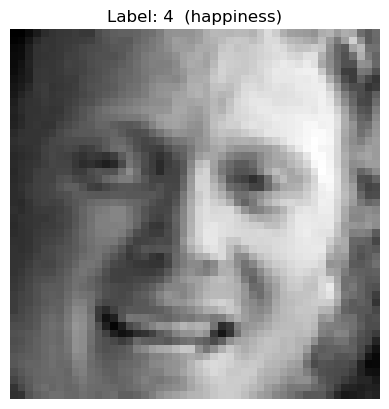

In [ ]:
# Shape
print("Shape of feature vectors: ", X.shape)
print("Shape of labels: ", Y.shape)

print("Number of features: ", X.shape[1] * X.shape[2])
print("Number of examples: ", X.shape[0])

# Example Image and Label (after scaling and normalization)
plt.imshow(X[5], cmap="gray")
plt.title(f"Label: {Y[5]}  ({list(class_idx.keys())[list(class_idx.values()).index(Y[5])]})")
plt.axis("off")
plt.show()

#### **Class distribution** 

There is a significant imbalance regarding the number of samples for neutral and happy faces. This suggests that models may become biased toward predicting these majority classes, so stratified sampling and evaluation metrics beyond accuracy (like confusion matrices) are necessary.

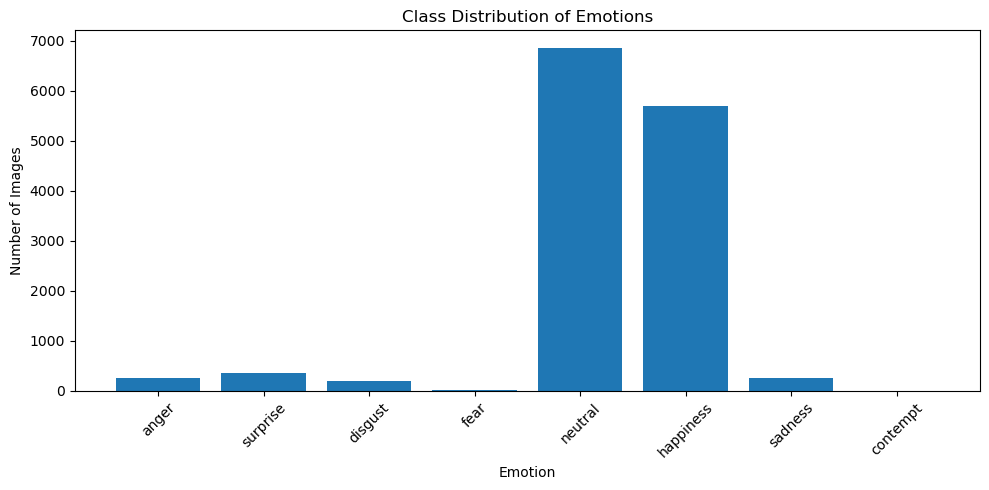

In [3]:
# Visualizing Class Distribution
counts = Counter(Y)
i_class = {i: c for c, i in class_idx.items()}
labels = [i_class[i] for i in counts.keys()]
counts = list(counts.values())

plt.figure(figsize=(10,5))
plt.bar(labels, counts)
plt.title("Class Distribution of Emotions")
plt.xlabel("Emotion")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **Pixel intensity** 

Most pixels fall between ~50 and ~200 which means images are moderately bright. There is a wide range of pixel intensities indicating there is lighting variability across the dataset. The shape indicates diversity across faces, lighting, and backgrounds and suggests that normalization is necessary and that models must be robust to variations in illumination (more complexity is favored).

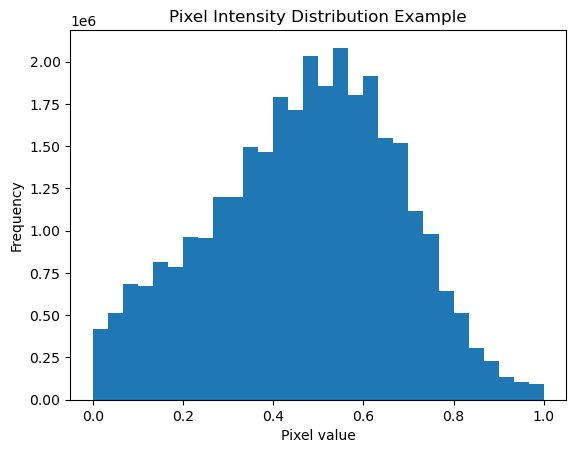

In [4]:
# Visualizing Pixel Distribution
plt.hist(X.flatten(), bins=30)
plt.title("Pixel Intensity Distribution Example")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

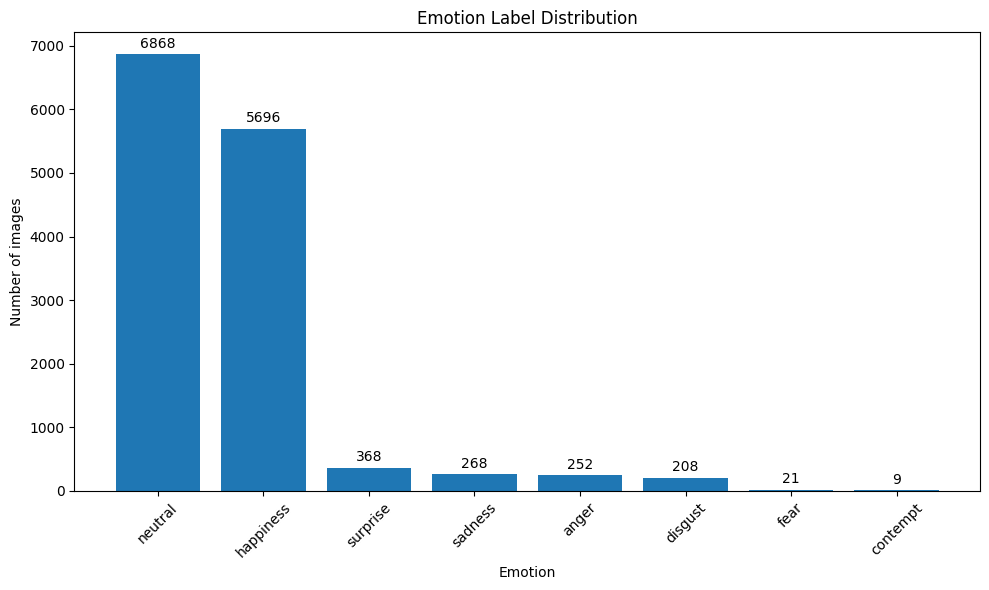

In [5]:
counts = Counter(Y)
emotions = [c for c in classes]
values = [counts[class_idx[c]] for c in classes]

# Sort by count (descending)
sorted_pairs = sorted(zip(emotions, values), key=lambda x: x[1], reverse=True)
emotions_sorted, values_sorted = zip(*sorted_pairs)

plt.figure(figsize=(10, 6))
bars = plt.bar(emotions_sorted, values_sorted)

# Add count labels on top of each bar
for bar, val in zip(bars, values_sorted):
  plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
           str(val), ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Number of images")
plt.title("Emotion Label Distribution")
plt.tight_layout()
plt.show()

#### **PCA Visualization**

Principle Component Analysis reduces each image to 2 dimensions so that we are able to visualize the 2 most important directions of variation in the images. This scatterplot shows that the data is not linearly separable, images are noisy, emotions visually overlap, and some expressions are subtle. Ultimately, this suggests that simple linear models (such as logistic regression or linear SVMs) are unlikely to perform well. The high overlap in PCA space also indicates that more complex nonlinear methods, such as SVMs with RBF kernels or convolutional neural networks, may be required to capture the structure of the data.

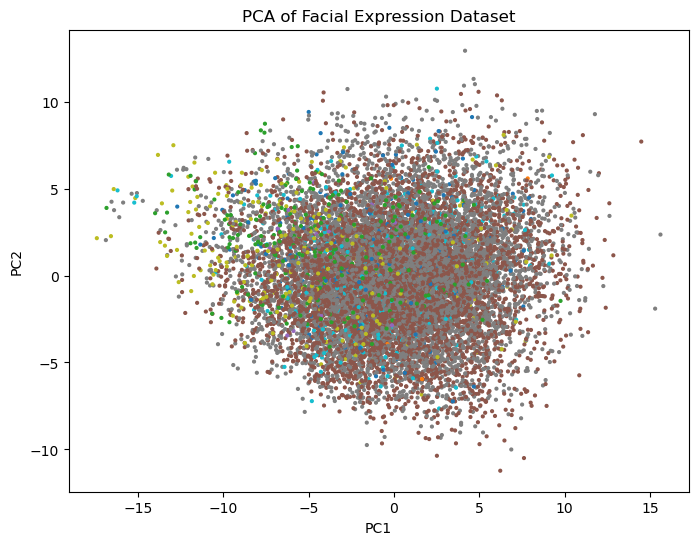

In [6]:
# PCA Visualization
X_flat = X.reshape(X.shape[0], -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y, cmap="tab10", s=4)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Facial Expression Dataset")
plt.show()

## **2: Model Training & Evaluation**
---

We trained multiple classifiers to predict emotions and compared their performance.

Data shapes: (13690, 2304) (13690,)

Baseline Model:
Most common emotion: 5
Baseline accuracy: 0.5018261504747992

Training Logistic Regression...


/Users/ethan/InsideOut/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.7030679327976626

Running PCA dimensionality reduction...

Training Linear SVM on PCA data...
Linear SVM (with PCA) accuracy: 0.766617969320672

Training Decision Tree...
Decision Tree accuracy: 0.5836376917457998

=== Accuracy Comparison ===
Baseline:            0.5018261504747992
Logistic Regression: 0.7030679327976626
Linear SVM:          0.766617969320672
Decision Tree:       0.5836376917457998

Best model: svm


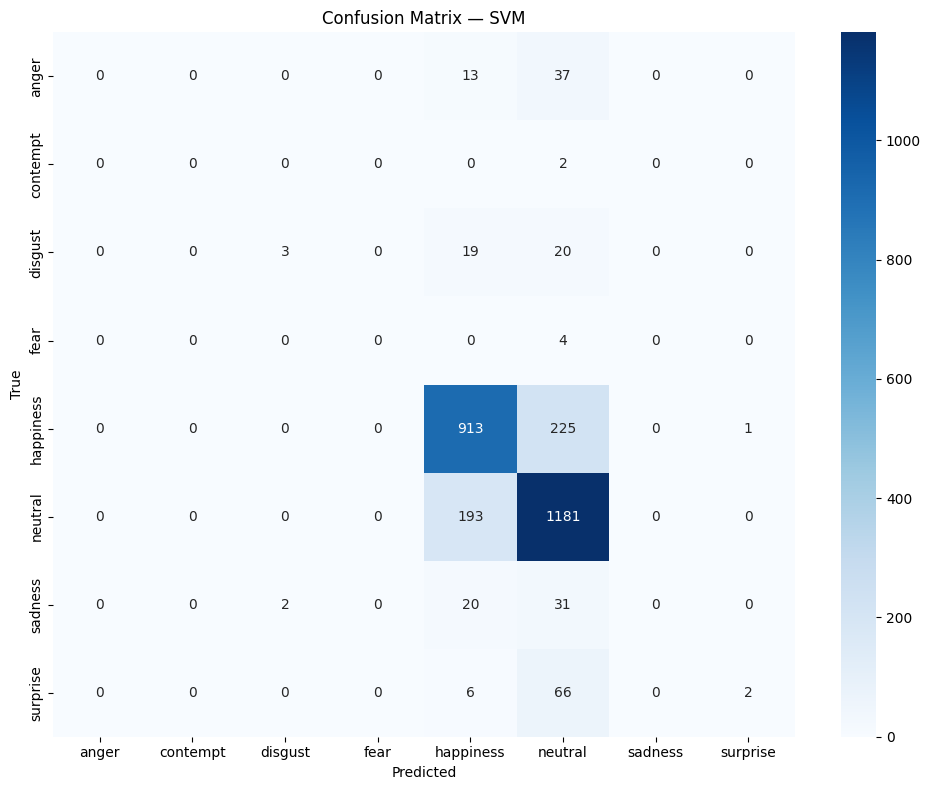

In [4]:
from model import run_models

classes = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

accuracies = run_models(X, Y, class_names=classes)